Epoch 1, Train Loss: 1.1280
Val Accuracy: 55.72%
Epoch 2, Train Loss: 1.1239
Val Accuracy: 55.72%
Epoch 3, Train Loss: 1.1235
Val Accuracy: 55.72%
Epoch 4, Train Loss: 1.1234
Val Accuracy: 55.72%
Epoch 5, Train Loss: 1.1231
Val Accuracy: 55.72%
Epoch 6, Train Loss: 1.1232
Val Accuracy: 55.72%
Epoch 7, Train Loss: 1.1230
Val Accuracy: 55.72%
Epoch 8, Train Loss: 1.1231
Val Accuracy: 55.72%
Epoch 9, Train Loss: 1.1231
Val Accuracy: 55.72%
Epoch 10, Train Loss: 1.1229
Val Accuracy: 55.72%
Test Accuracy on G:\GlitchDetect\supervised_learning_non_seq\generated_data\24hrs_100_with_faults.csv: 0.7208


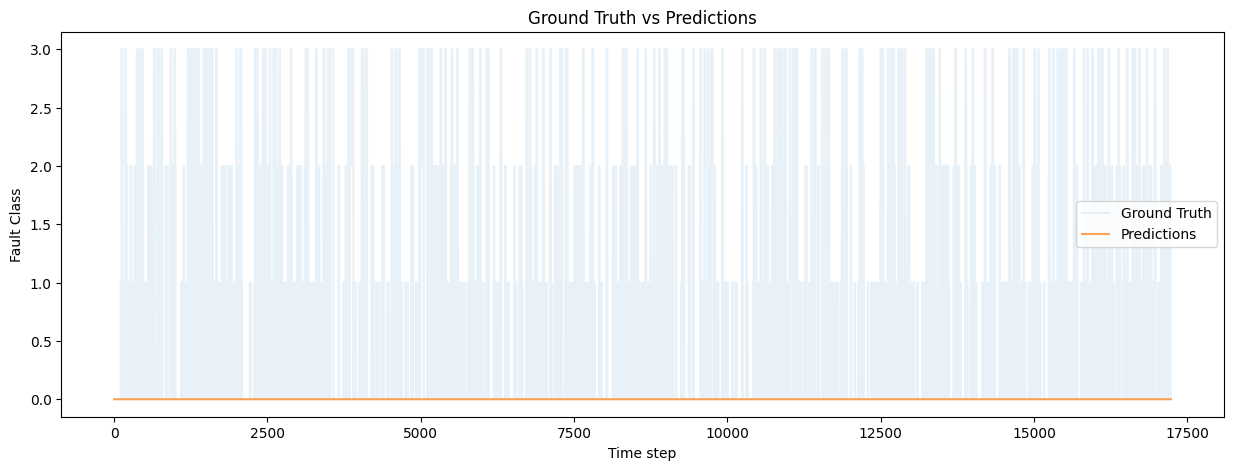

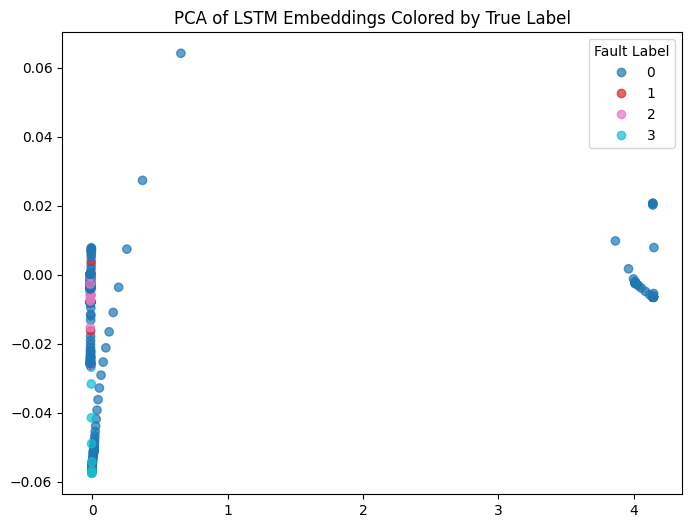

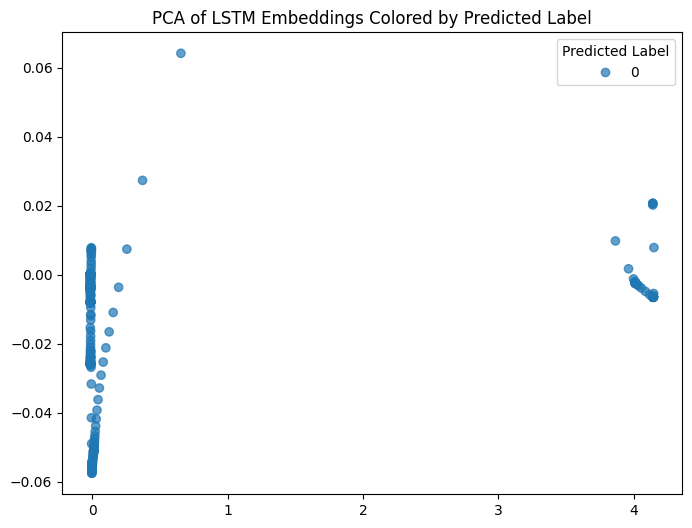

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# ------------------------------
# 1. Prepare Data
# ------------------------------
def create_sequences(data, labels, seq_len=50):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(labels[i+seq_len])   # label at end of sequence
    return np.array(xs), np.array(ys)

# Load training CSV
train_path = r'G:\GlitchDetect\Temporal_models\100_hr_fault.csv'
df = pd.read_csv(train_path)

data = df.drop(columns=['fault_label'])
labels = df['fault_label']

X, y = create_sequences(data.values, labels.values, seq_len=50)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ------------------------------
# 2. Define LSTM Model
# ------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        hn = hn[-1]  # last hidden state
        return self.fc(hn)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[2]
num_classes = len(np.unique(y))  # dynamically pick classes
model = LSTMClassifier(input_dim=input_dim, hidden_dim=64, num_layers=2, num_classes=num_classes).to(device)

# ------------------------------
# 3. Training
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # increase epochs if needed
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    print(f"Val Accuracy: {100 * correct/total:.2f}%")
    torch.save(model.state_dict(), 'lstm_model.pth')

# ------------------------------
# 4. Test on Different CSV
# ------------------------------
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def test_on_csv(test_path, model, seq_len=50, plot=True):
    df_test = pd.read_csv(test_path)
    data_test = df_test.drop(columns=['fault_label'])
    labels_test = df_test['fault_label']

    X_test, y_test = create_sequences(data_test.values, labels_test.values, seq_len=seq_len)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = outputs.argmax(dim=1).cpu().numpy()
    
    acc = (preds == y_test_tensor.cpu().numpy()).sum() / len(y_test_tensor)
    print(f"Test Accuracy on {test_path}: {acc:.4f}")

    # ---------- Plot predictions vs ground truth ----------
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(y_test, label="Ground Truth", alpha=0.1)
        plt.plot(preds, label="Predictions", alpha=0.7)
        plt.title("Ground Truth vs Predictions")
        plt.xlabel("Time step")
        plt.ylabel("Fault Class")
        plt.legend()
        plt.show()

    # ---------- PCA Visualization of sequence embeddings ----------
    if plot:
        # take the LSTM hidden outputs for PCA
        model.eval()
        with torch.no_grad():
            lstm_out, (hn, cn) = model.lstm(X_test_tensor)
            embeddings = hn[-1].cpu().numpy()  # last hidden state as embedding

        pca = PCA(n_components=2)
        reduced = pca.fit_transform(embeddings)

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(reduced[:,0], reduced[:,1], c=y_test, cmap="tab10", alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Fault Label")
        plt.title("PCA of LSTM Embeddings Colored by True Label")
        plt.show()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(reduced[:,0], reduced[:,1], c=preds, cmap="tab10", alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Predicted Label")
        plt.title("PCA of LSTM Embeddings Colored by Predicted Label")
        plt.show()


# Example usage:
test_path = r'G:\GlitchDetect\supervised_learning_non_seq\generated_data\24hrs_100_with_faults.csv'
test_on_csv(test_path, model)


Using device: cuda
Epoch 1/20, Loss: 0.005810
Epoch 2/20, Loss: 0.003240
Epoch 3/20, Loss: 0.001763
Epoch 4/20, Loss: 0.001514
Epoch 5/20, Loss: 0.001426
Epoch 6/20, Loss: 0.001355
Epoch 7/20, Loss: 0.001312
Epoch 8/20, Loss: 0.001283
Epoch 9/20, Loss: 0.001252
Epoch 10/20, Loss: 0.001239
Epoch 11/20, Loss: 0.001231
Epoch 12/20, Loss: 0.001216
Epoch 13/20, Loss: 0.001206
Epoch 14/20, Loss: 0.001208
Epoch 15/20, Loss: 0.001189
Epoch 16/20, Loss: 0.001197
Epoch 17/20, Loss: 0.001175
Epoch 18/20, Loss: 0.001180
Epoch 19/20, Loss: 0.001174
Epoch 20/20, Loss: 0.001170
Threshold:  0.002772463


C:\Users\adith\AppData\Local\Temp\ipykernel_7808\1361672124.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\adith\AppData\Local\Temp\ipykernel_7808\1361672124.py:131: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
c:\Users\adith\miniconda3\envs\torch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


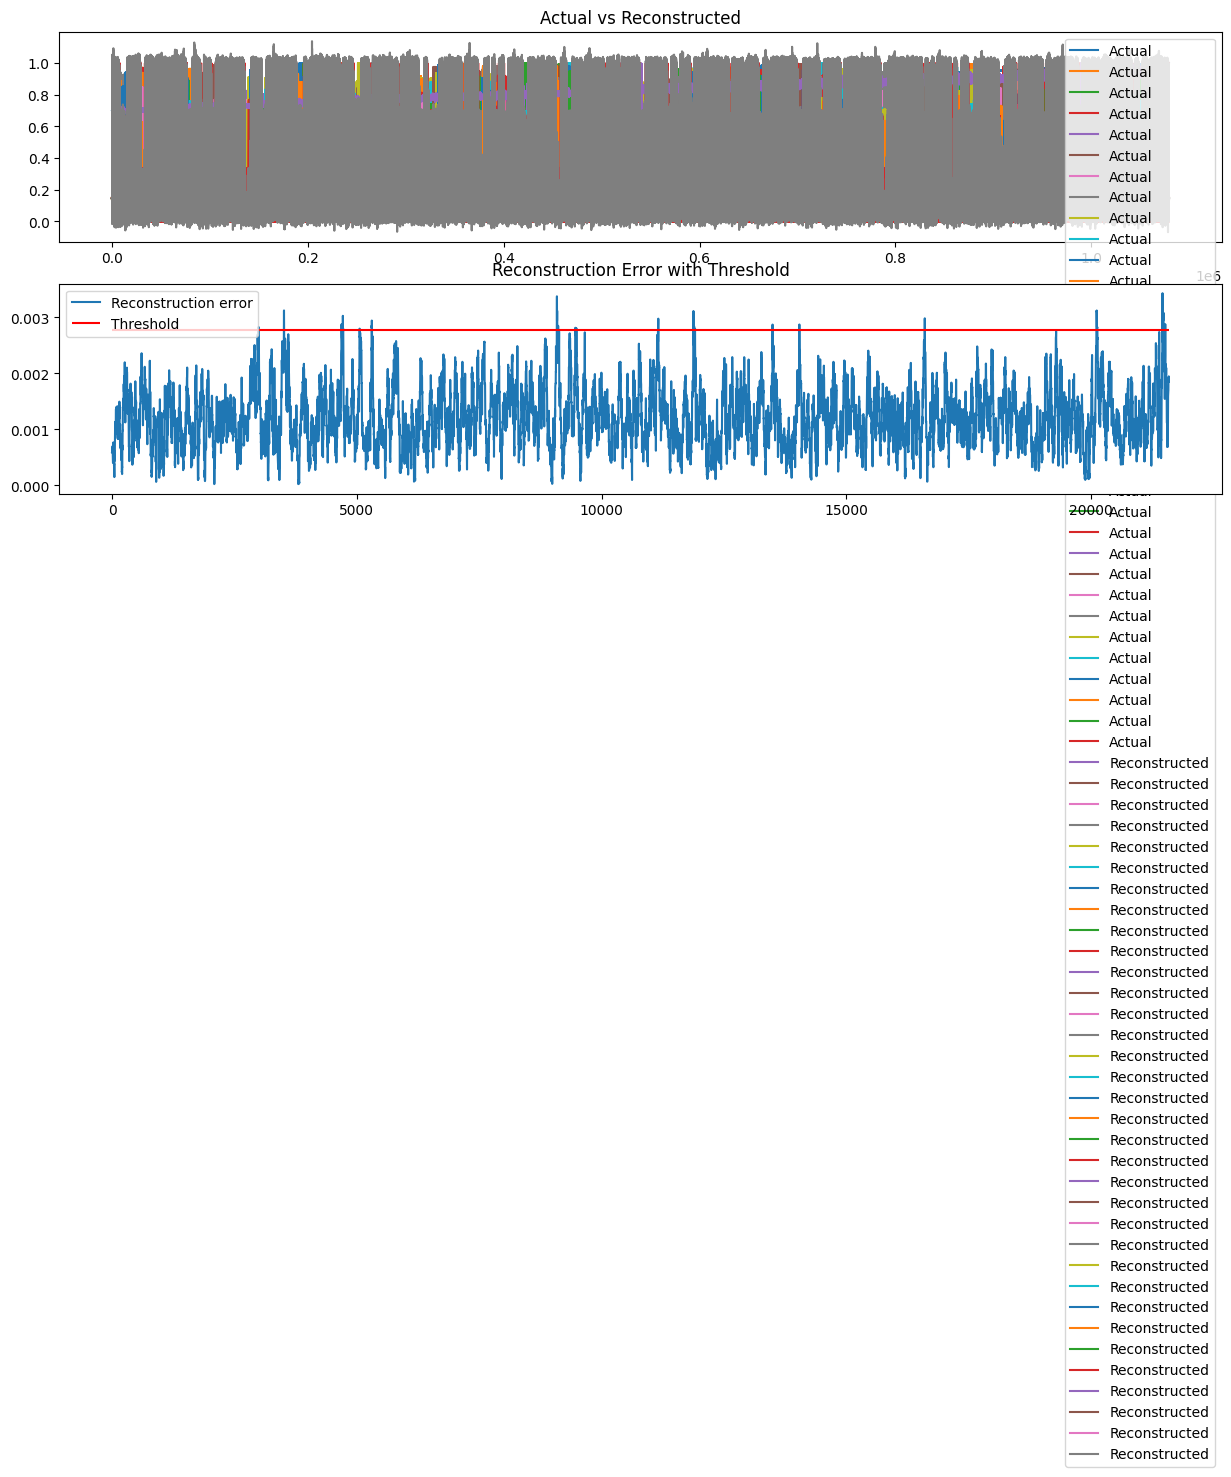

ValueError: x and y must be the same size

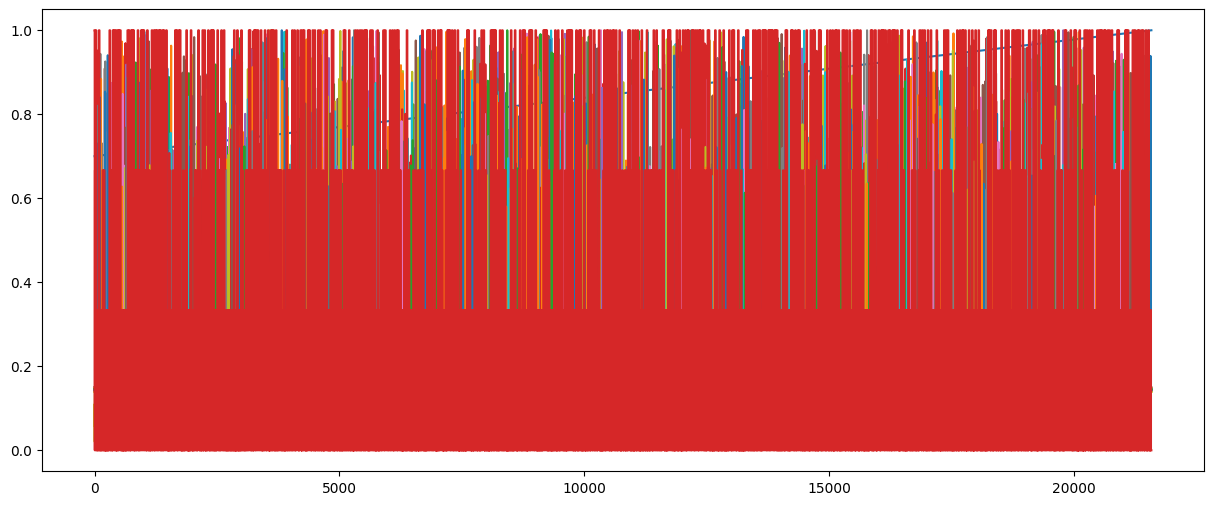

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# 1. Load Data
# -------------------------
df = pd.read_csv(r"G:\GlitchDetect\Temporal_models\100_hr_fault.csv")
values = df.values.astype(float)

# -------------------------
# 2. Normalize
# -------------------------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# -------------------------
# 3. Create Sequences
# -------------------------
SEQ_LEN = 50

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i+seq_len)]
        y = data[i:(i+seq_len)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, Y = create_sequences(scaled, SEQ_LEN)

# Train/test split
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Convert to torch tensors and move to GPU if available
torch_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
torch_Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
torch_X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
torch_Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(torch_X_train, torch_Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -------------------------
# 4. LSTM Autoencoder
# -------------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_dim=64, seq_len=SEQ_LEN):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, n_features)
    
    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden_repeated = hidden.repeat(self.seq_len, 1, 1).permute(1,0,2)
        decoded, _ = self.decoder(hidden_repeated)
        out = self.output_layer(decoded)
        return out

n_features = X.shape[2]
model = LSTMAutoencoder(n_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------
# 5. Train
# -------------------------
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    losses = []
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses):.6f}")

# Save model
torch.save(model.state_dict(), "lstm_autoencoder_model.pth")

# -------------------------
# 6. Reconstruction Error
# -------------------------
model.eval()
with torch.no_grad():
    X_pred = model(torch_X_test)
reconstruction_error = torch.mean((X_pred - torch_Y_test)**2, dim=(1,2)).cpu().numpy()

# -------------------------
# 7. Threshold for anomaly
# -------------------------
threshold = np.mean(reconstruction_error) + 3*np.std(reconstruction_error)
print("Threshold: ", threshold)

anomalies = reconstruction_error > threshold

# -------------------------
# 8. Plot
# -------------------------
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(torch_Y_test.cpu().numpy().reshape(-1, n_features), label="Actual")
plt.plot(X_pred.cpu().numpy().reshape(-1, n_features), label="Reconstructed")
plt.title("Actual vs Reconstructed")
plt.legend()

plt.subplot(2,1,2)
plt.plot(reconstruction_error, label="Reconstruction error")
plt.hlines(threshold, xmin=0, xmax=len(reconstruction_error), colors='r', label="Threshold")
plt.title("Reconstruction Error with Threshold")
plt.legend()
plt.tight_layout()
plt.show()

# Plot anomalies on original signal
plt.figure(figsize=(15,6))
plt.plot(scaled[train_size+SEQ_LEN:], label="Sensor signal")
plt.scatter(np.where(anomalies)[0], scaled[train_size+SEQ_LEN:][anomalies], color='r', label="Anomaly")
plt.legend()
plt.show()

In [11]:
import torch  # import the class you used
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load new data
df_new = pd.read_csv(r"100_hr_fault.csv")
values_new = df_new.values.astype(float)

# Normalize using the same scaler you used before
scaler = MinMaxScaler()
scaled_new = scaler.fit_transform(values_new)  # or use same scaler params if saved

# Convert to tensor
torch_X_new = torch.tensor(scaled_new, dtype=torch.float32).to(device)

# Load model
n_features = scaled_new.shape[1]
model = LSTMAutoencoder(n_features).to(device)
model.load_state_dict(torch.load("lstm_autoencoder_model.pth", map_location=device))
model.eval()


LSTMAutoencoder(
  (encoder): LSTM(34, 64, batch_first=True)
  (decoder): LSTM(64, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=34, bias=True)
)

In [12]:
SEQ_LEN = 50

def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len):
        x = data[i:(i+seq_len)]
        xs.append(x)
    return torch.tensor(xs, dtype=torch.float32).to(device)

X_seq_new = create_sequences(scaled_new, SEQ_LEN)


C:\Users\adith\AppData\Local\Temp\ipykernel_7808\2390355135.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(xs, dtype=torch.float32).to(device)


In [13]:
with torch.no_grad():
    X_recon = model(X_seq_new)  # shape: [num_seq, SEQ_LEN, n_features]

# Convert back to numpy
X_recon_np = X_recon.cpu().numpy()



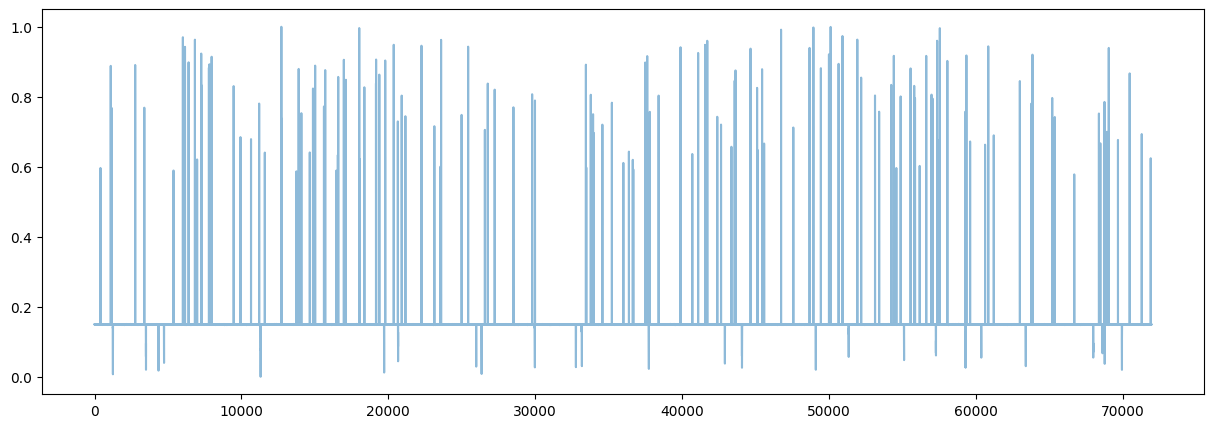

In [20]:
sensor_idx = 1  # change to your sensor index
reconstructed_sensor = X_recon_np[:, :, sensor_idx].flatten()
original_sensor = scaled_new[SEQ_LEN:, sensor_idx]  # aligned with sequences
plt.figure(figsize=(15,5))
plt.plot(original_sensor, label="Original Sensor Data", alpha=0.5)


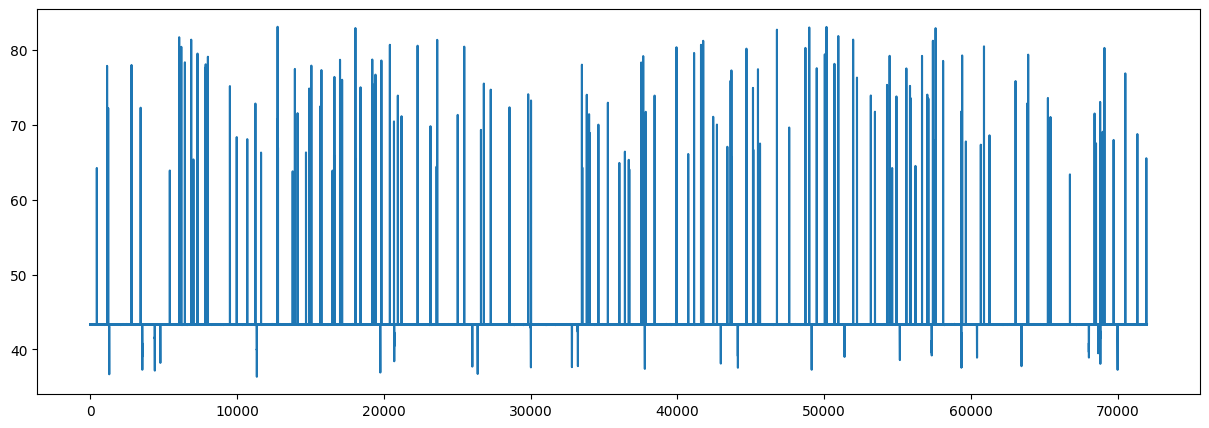

In [24]:
plt.figure(figsize=(15, 5))

plt.plot(df['P1_PS_DN'])

In [25]:
reconstructed = np.zeros_like(scaled_new)  # full reconstruction
counts = np.zeros(len(scaled_new))         # count how many times each timestep is predicted

with torch.no_grad():
    for i in range(len(scaled_new) - SEQ_LEN):
        seq = scaled_new[i:i+SEQ_LEN]
        seq_tensor = torch.tensor(seq[None,:,:], dtype=torch.float32).to(device)  # add batch dim
        recon_seq = model(seq_tensor).cpu().numpy()[0]  # remove batch dim
        reconstructed[i:i+SEQ_LEN] += recon_seq
        counts[i:i+SEQ_LEN] += 1

# Average overlapping predictions
reconstructed /= counts[:, None]

C:\Users\adith\AppData\Local\Temp\ipykernel_7808\2715235553.py:13: RuntimeWarning: invalid value encountered in divide
  reconstructed /= counts[:, None]


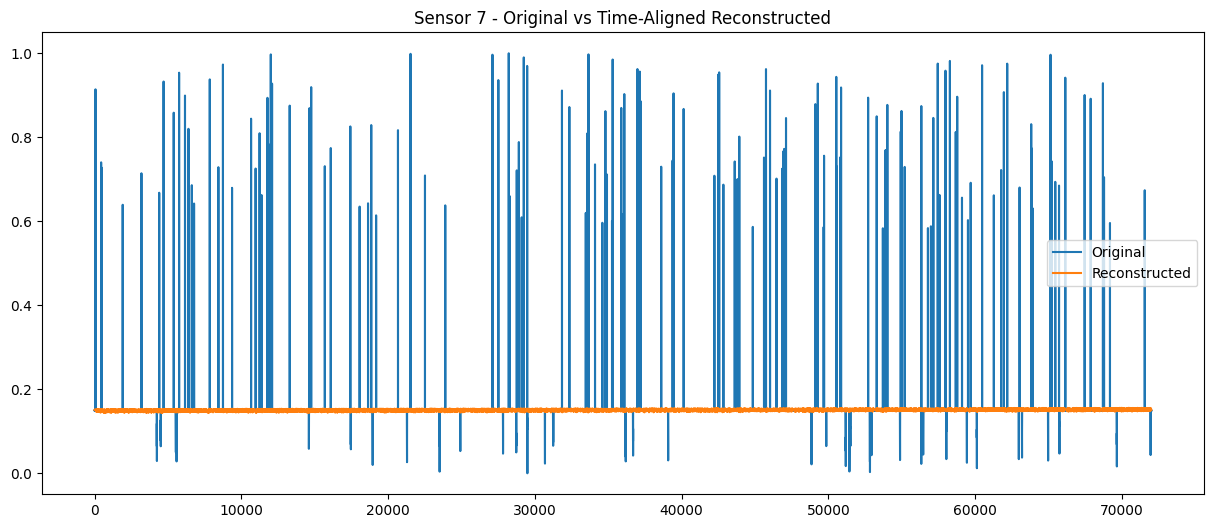

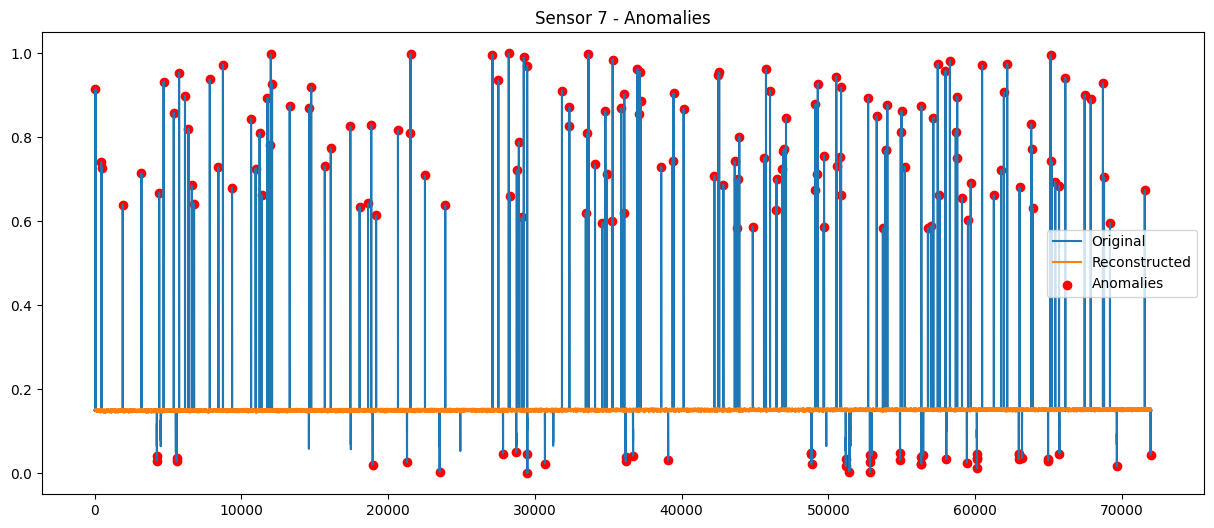

192


In [41]:
sensor_idx = 7  # choose the sensor column
plt.figure(figsize=(15,6))
plt.plot(scaled_new[:, sensor_idx], label="Original")
plt.plot(reconstructed[:, sensor_idx], label="Reconstructed")
plt.title(f"Sensor {sensor_idx} - Original vs Time-Aligned Reconstructed")
plt.legend()
plt.show()

#show anomalies with red points on the data itself
anomalies = np.abs(reconstructed - scaled_new) > 0.1  # threshold for anomalies
plt.figure(figsize=(15,6))
plt.plot(scaled_new[:, sensor_idx], label="Original")
plt.plot(reconstructed[:, sensor_idx], label="Reconstructed")
plt.scatter(np.where(anomalies[:, sensor_idx])[0], scaled_new[anomalies[:, sensor_idx], sensor_idx], color='red', label="Anomalies")
plt.title(f"Sensor {sensor_idx} - Anomalies")
plt.legend()
plt.show()

print(len(np.where(anomalies[:, sensor_idx])[0]))
